## Cell 1: Install & Imports

In [65]:
import torch

!pip install optuna -q
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y -q
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html -q
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html -q
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html -q
!pip install git+https://github.com/pyg-team/pytorch_geometric.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [66]:
# data & geospatial
import numpy as np
import pandas as pd
import geopandas as gpd

# graph handling
import networkx as nx

# scikit‐learn utilities
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# progress bars
from tqdm.auto import tqdm

# miscellaneous
import random
from collections import Counter

# plotting
import matplotlib.pyplot as plt

# PyTorch & PyTorch‐Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv

# Mounting drive
from google.colab import drive

# This will prompt you to authorize Colab to access your Drive.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cell 2: Load & preprocess GeoDataFrame

In [67]:
# 2.1) load your street segments GeoJSON
fp = '/content/drive/MyDrive/Universiteit Utrecht/Thesis/data/road_network_lufeature.geojson'
gdf = gpd.read_file(fp).to_crs(epsg=28992)

# 2.2) reset index so `idx` is our node ID
gdf = gdf.reset_index(drop=True)

# 2.3) compute centroids & coords array
gdf['centroid'] = gdf.geometry.centroid
coords = np.vstack([ (pt.x, pt.y) for pt in gdf.centroid ])

# 2.4) choose your full list of features + target
feature_cols = [
    'AGRI_100','INDUS_100','NATUR_100','PORT_100','RES_100','TRANS_100','URBG_100','WATER_100',
    'AGRI_300','INDUS_300','NATUR_300','PORT_300','RES_300','TRANS_300','URBG_300','WATER_300',
    'AGRI_500','INDUS_500','NATUR_500','PORT_500','RES_500','TRANS_500','URBG_500','WATER_500',
    'AGRI_1000','INDUS_1000','NATUR_1000','PORT_1000','RES_1000','TRANS_1000','URBG_1000','WATER_1000',
    'AGRI_5000','AIR_5000','INDUS_5000','NATUR_5000','PORT_5000','RES_5000','TRANS_5000','URBG_5000','WATER_5000',
    'POP_100','POP_300','POP_500','POP_1000','POP_5000',
    'EEA_100','EEA_300','EEA_500','EEA_1000','EEA_5000',
    'HHOLD_100','HHOLD_300','HHOLD_500','HHOLD_1000',
    'RDL_25','TLOA_25','HLOA_25','MRDL_25','TMLOA_25','HMLOA_25',
    'RDL_50','TLOA_50','HLOA_50','MRDL_50','TMLOA_50','HMLOA_50',
    'RDL_100','TLOA_100','HLOA_100','MRDL_100','TMLOA_100','HMLOA_100',
    'RDL_300','TLOA_300','HLOA_300','MRDL_300','TMLOA_300','HMLOA_300',
    'RDL_500','TLOA_500','HLOA_500','MRDL_500','TMLOA_500','HMLOA_500',
    'RDL_1000','TLOA_1000','HLOA_1000','MRDL_1000','TMLOA_1000','HMLOA_1000',
    'TRAFNEAR','HTRAFNEAR','DINVNEAR','TRAFMAJOR','HTRAFMAJOR','DINVMAJOR'
]
target_col = 'NO2d'


## Cell 3: Build Road‐Segment Graph

In [68]:
def build_road_graph(
    gdf,
    feature_cols,
    target_col,
    plot_graph=True,
    print_stats=True,
    save_to_drive_path=None
):
    """
    Constructs a NetworkX graph from a GeoDataFrame where each segment is a node
    and edges connect touching segments. Nodes are not dropped for missing data.

    Parameters:
    - gdf: GeoDataFrame with road segments
    - feature_cols: list of feature column names
    - target_col: name of the target variable
    - plot_graph: whether to visualize the graph with node coloring by missing data
    - print_stats: whether to print node/edge counts and degree stats
    - save_to_drive_path: if provided, saves the graph object using pickle

    Returns:
    - G: NetworkX graph
    - gdf: Original GeoDataFrame (reset index)
    """

    gdf = gdf.copy().reset_index(drop=True)
    G = nx.Graph()

    # Precompute missing value masks
    missing_target = gdf[target_col].isnull()
    missing_features = gdf[feature_cols].isnull().any(axis=1)

    if print_stats:
        print(f"Total nodes: {len(gdf)}")
        print(f"Nodes with missing target ({target_col}): {missing_target.sum()}")
        print(f"Nodes with missing feature(s): {missing_features.sum()}")

    print("Adding nodes...")
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Nodes"):
        G.add_node(idx, **row.drop('geometry').to_dict())

    print("Building spatial index...")
    subset_sindex = gdf.sindex

    print("Adding edges...")
    for idx, geom in tqdm(enumerate(gdf.geometry), total=len(gdf), desc="Edges"):
        possible_neighbors = list(subset_sindex.intersection(geom.bounds))
        for neighbor_idx in possible_neighbors:
            if idx != neighbor_idx:
                neighbor_geom = gdf.geometry[neighbor_idx]
                if geom.touches(neighbor_geom):
                    G.add_edge(idx, neighbor_idx)

    if print_stats:
        print(f"Number of edges: {G.number_of_edges()}")
        degrees = [d for _, d in G.degree()]
        print(f"Average degree: {sum(degrees)/len(degrees):.2f}")

    if plot_graph:
        print("Preparing graph plot...")
        pos = {
            idx: (geom.centroid.x, geom.centroid.y)
            for idx, geom in enumerate(gdf.geometry)
        }

        node_colors = []
        for i in range(len(gdf)):
            if missing_target[i]:
                node_colors.append('red')
            elif missing_features[i]:
                node_colors.append('orange')
            else:
                node_colors.append('blue')

        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, node_size=10, edge_color='gray', node_color=node_colors, with_labels=False)
        # Legend
        import matplotlib.patches as mpatches
        legend_handles = [
            mpatches.Patch(color='red', label='Missing target'),
            mpatches.Patch(color='orange', label='Missing features'),
            mpatches.Patch(color='blue', label='No missing data'),
        ]
        plt.legend(handles=legend_handles, loc='upper right')
        plt.axis('equal')
        plt.show()

    if save_to_drive_path:
        with open(save_to_drive_path, 'wb') as f:
            pickle.dump(G, f)
        if print_stats:
            print(f"💾 Graph saved to: {save_to_drive_path}")

    return G, gdf

# invoke it:
G, gdf = build_road_graph(
    gdf, feature_cols, target_col,
    plot_graph=False, print_stats=True
)

Total nodes: 48595
Nodes with missing target (NO2d): 1931
Nodes with missing feature(s): 0
Adding nodes...


Nodes:   0%|          | 0/48595 [00:00<?, ?it/s]

Building spatial index...
Adding edges...


Edges:   0%|          | 0/48595 [00:00<?, ?it/s]

Number of edges: 56998
Average degree: 2.35


## Cell 4 augmented graph design

In [69]:
def augment_grouped_far_knn(
    G,
    gdf,
    groups: dict,
    coords: np.ndarray,
    feature_matrix: np.ndarray,
    feature_cols: list,
    top_n: int = 500,
    neighbors: int = 50,
    sim_thresh: float = 0.9,
    min_dist: float = 200.0,
    max_dist: float = 2000.0,
    hop_thresh: int = 3,
    max_edges: int = 3000,
    per_node_cap: int = 5,
    road_id_col: str = "ROAD_FID",
    suffix: str = 'grp_far_knn'
):
    """
    1) For each group, pick the top_n segments by intensity.
    2) In feature‐space (cosine), find each’s `neighbors` nearest peers.
       Keep only those with sim ≥ sim_thresh.
    3) Filter by:
       - Euclidean distance ≥ min_dist and ≤ max_dist,
       - Graph‐hop distance > hop_thresh,
       - Different ROAD_FID.
    4) Enforce per_node_cap & global max_edges.
    """
    road_ids = gdf[road_id_col].to_numpy()
    candidates = set()

    # 1) Propose semantic candidates
    for grp, cols in tqdm(groups.items(), desc="Groups", total=len(groups)):
        # pick top_n by group‐intensity
        intensity = gdf[cols].sum(axis=1)
        top_idx   = intensity.nlargest(top_n).index.to_numpy()
        if top_idx.size < 2:
            continue

        # extract + normalize features for just this group
        subF = feature_matrix[top_idx][:, [feature_cols.index(c) for c in cols]]
        norms = np.linalg.norm(subF, axis=1, keepdims=True).clip(min=1e-6)
        subF_n = subF / norms

        # feature‐space kNN
        nbr = NearestNeighbors(
            n_neighbors=min(neighbors+1, len(top_idx)),
            metric='cosine'
        ).fit(subF_n)
        dists, idxs = nbr.kneighbors(subF_n)
        sims = 1 - dists  # cosine similarity

        # for each source, propose any peer above sim_thresh
        for ii, src in enumerate(top_idx):
            # precompute “too‐close” graph‐neighbors
            close = set(nx.single_source_shortest_path_length(
                G, int(src), cutoff=hop_thresh
            ).keys())

            for rank, dst_j in enumerate(idxs[ii,1:]):
                if sims[ii, rank+1] < sim_thresh:
                    break   # further ones only lower sim
                dst = top_idx[dst_j]
                u, v = sorted((int(src), int(dst)))

                # same‐road?
                if road_ids[src] == road_ids[dst]:
                    continue

                # Euclidean distance
                d_xy = np.hypot(*(coords[src] - coords[dst]))
                if d_xy < min_dist or d_xy > max_dist:
                    continue

                # already near in graph?
                if dst in close:
                    continue

                candidates.add((u, v))

    # 2) Trim to per‐node and global budgets
    final, counts = [], Counter()
    all_c = list(candidates)
    random.shuffle(all_c)
    for u, v in all_c:
        if counts[u] < per_node_cap and counts[v] < per_node_cap:
            final.append((u, v))
            counts[u] += 1
            counts[v] += 1
        if len(final) >= max_edges:
            break

    # 3) Build augmented graph
    G2 = G.copy()
    G2.add_edges_from(final, feature_sim=suffix)
    return G2, final


# ─────────────── Usage with Best Parameters ──────────────────────────────────

# 0) Define your groups
groups = {
    'industrial':        ['INDUS_300','INDUS_1000'],
    'residential':       ['RES_300','RES_1000'],
    'agriculture':       ['AGRI_300','AGRI_1000'],
    'natural':           ['NATUR_300','NATUR_1000'],
    'port':              ['PORT_300','PORT_1000'],
    'urb_built':         ['URBG_300','URBG_1000'],
    'water':             ['WATER_300','WATER_1000'],
    'traffic':           ['TRAFNEAR','TRAFMAJOR'],
    'pop':               ['POP_300','POP_1000'],
    'population_density':['EEA_300','EEA_1000'],
}

# 1) Build feature_matrix
feature_matrix = gdf[feature_cols].to_numpy()  # shape (N, F)

# 2) Extract coordinates from centroids
coords = np.column_stack((
    gdf.geometry.centroid.x.values,
    gdf.geometry.centroid.y.values
))

# 3) Run augmentation with best parameters
G, new_far = augment_grouped_far_knn(
    G=G,
    gdf=gdf,
    groups=groups,
    coords=coords,
    feature_matrix=feature_matrix,
    feature_cols=feature_cols,
    top_n=2000,             # same as during grid search
    neighbors=500,          # ← best param
    sim_thresh=0.995,       # ← best param
    min_dist=200.0,         # ← fixed in grid
    max_dist=4000.0,        # ← best param
    hop_thresh=4,           # ← best param
    max_edges=2000,         # ← best param
    per_node_cap=2,         # ← best param
    road_id_col="ROAD_FID",
    suffix='best_augmented'
)

print(f"\n✅ Far-range grouped-kNN added: {len(new_far)} edges\n")


Groups:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Far-range grouped-kNN added: 2000 edges



## Cell 5: Summarize & Plot graph augmentation

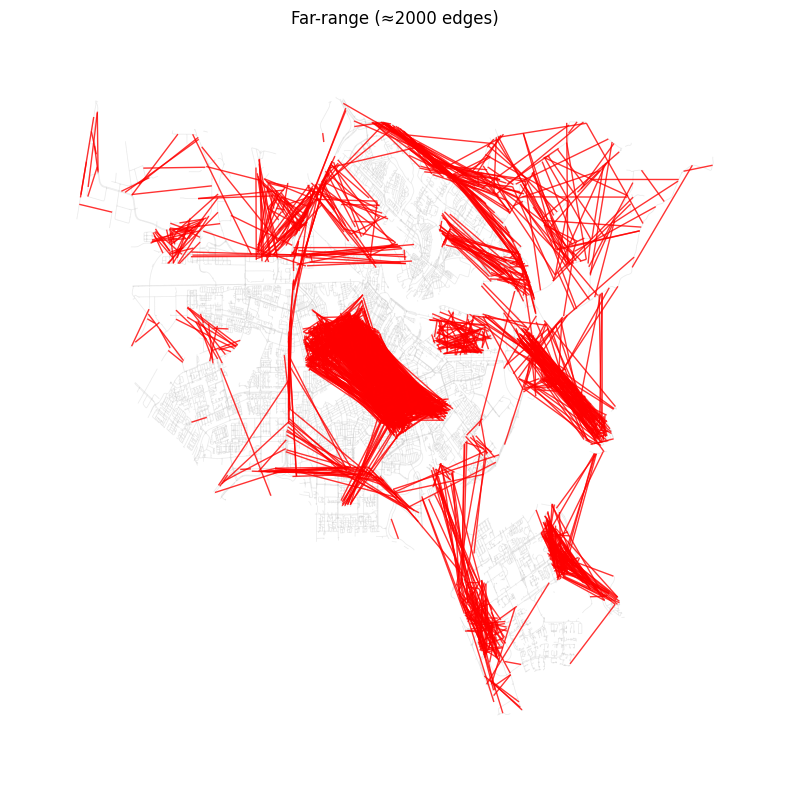

In [70]:
def plot_aug(
    G,
    coords,
    title=None,
    node_size=0,
    base_edge_kwargs=None,
    new_edge_kwargs=None
):
    """
    Draws G’s original edges in light gray and overlays 'feature_sim' edges in red.

    Parameters
    ----------
    G : networkx.Graph
      Graph whose nodes are integers 0..N-1 and whose edges may carry a
      'feature_sim' attribute flag.
    coords : ndarray of shape (N,2)
      coords[i] = (x_i, y_i) for node i.
    title : str, optional
      Title for the plot.
    node_size : int, default=0
      If >0, draw nodes as black dots of this size.
    base_edge_kwargs : dict, optional
      Passed to nx.draw_networkx_edges for original edges.
    new_edge_kwargs  : dict, optional
      Passed to nx.draw_networkx_edges for 'feature_sim' edges.
    """
    # default styling for original vs. new edges
    base_edge_kwargs = base_edge_kwargs or dict(edge_color='lightgray', alpha=0.5, width=0.5)
    new_edge_kwargs  = new_edge_kwargs  or dict(edge_color='red',        alpha=0.8, width=1.0)

    # build a position mapping for all nodes
    pos = {i: coords[i] for i in G.nodes()}

    plt.figure(figsize=(8, 8))
    # draw all original edges (those without 'feature_sim')
    orig_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('feature_sim')]
    nx.draw_networkx_edges(G, pos, edgelist=orig_edges, **base_edge_kwargs)

    # draw only the new 'feature_sim' edges
    new_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('feature_sim')]
    nx.draw_networkx_edges(G, pos, edgelist=new_edges, **new_edge_kwargs)

    # optionally draw nodes
    if node_size > 0:
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='black')

    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_aug(G, coords, title=f"Far-range (≈{len(new_far)} edges)")

## Cell 6

In [71]:
scaler = StandardScaler()
gdf[feature_cols] = scaler.fit_transform(gdf[feature_cols])

In [72]:
# Relabel nodes in G to match DataFrame row indices (0..N-1)
G = nx.relabel_nodes(G, {old_idx: new_idx for new_idx, old_idx in enumerate(gdf.index)})

# Edge index from graph (undirected)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)

# Node features
x = torch.tensor(gdf[feature_cols].values, dtype=torch.float)

# Target labels
y_np = gdf[target_col].values.astype(np.float32)
y = torch.tensor(y_np).view(-1, 1)

# Create the Data object
data = Data(x=x, edge_index=edge_index, y=y)

In [73]:
# Print summary
print(data)
print(f"Node features shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Target shape: {data.y.shape}")

Data(x=[48595, 97], edge_index=[2, 117996], y=[48595, 1])
Node features shape: torch.Size([48595, 97])
Edge index shape: torch.Size([2, 117996])
Target shape: torch.Size([48595, 1])


In [74]:
# Set seed for reproducibility
torch.manual_seed(42)

# Find valid (non-NaN) target indices
valid_idx = ~np.isnan(y_np)
valid_indices = np.where(valid_idx)[0]
perm = torch.randperm(len(valid_indices))
n_train = int(0.8 * len(valid_indices))

# Split into train/test using valid indices only
train_idx = torch.tensor(valid_indices[perm[:n_train]])
test_idx  = torch.tensor(valid_indices[perm[n_train:]])

# Create train/test masks
train_mask = torch.zeros(len(gdf), dtype=torch.bool)
test_mask  = torch.zeros(len(gdf), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx]   = True

# Attach masks to data object
data.train_mask = train_mask
data.test_mask = test_mask

In [75]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
 #       self.conv4 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
 #       x = self.conv4(x, edge_index)
 #       x = F.relu(x)
        return x

<ipython-input-76-0ee9a031364f>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pearson_corr = float(pearson_corr)


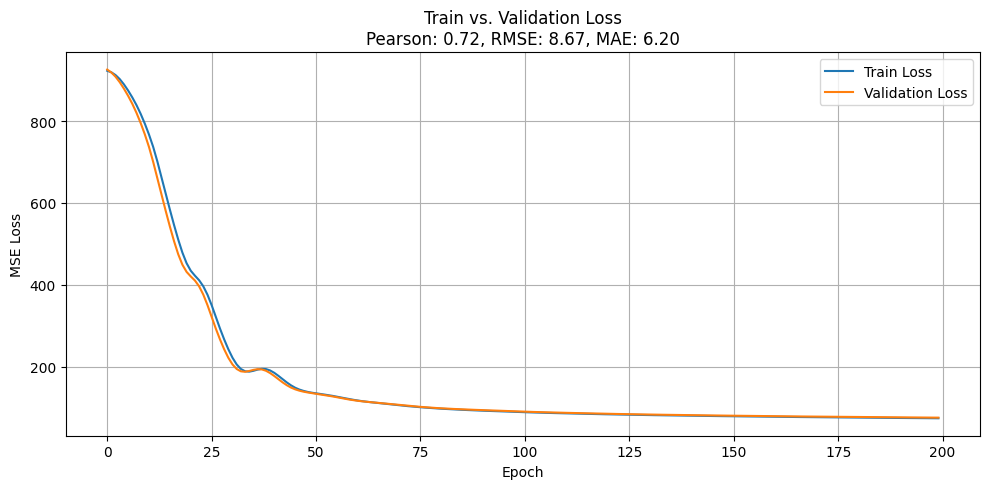

In [76]:
# Define model, optimizer, loss function
loss_fn = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Initialize model and optimizer
model = GCN(in_channels=len(feature_cols), hidden_channels=16, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
val_losses = []

# Training loop with both train and validation loss
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        val_loss = loss_fn(out[data.test_mask], data.y[data.test_mask])

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

# Evaluation after training
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index)
    pred_test = pred[data.test_mask].cpu().numpy()
    y_test = data.y[data.test_mask].cpu().numpy()

# Metrics
mse = mean_squared_error(y_test, pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)
pearson_corr, _ = pearsonr(y_test, pred_test)
pearson_corr = float(pearson_corr)

# Plot both train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'Train vs. Validation Loss\nPearson: {pearson_corr:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


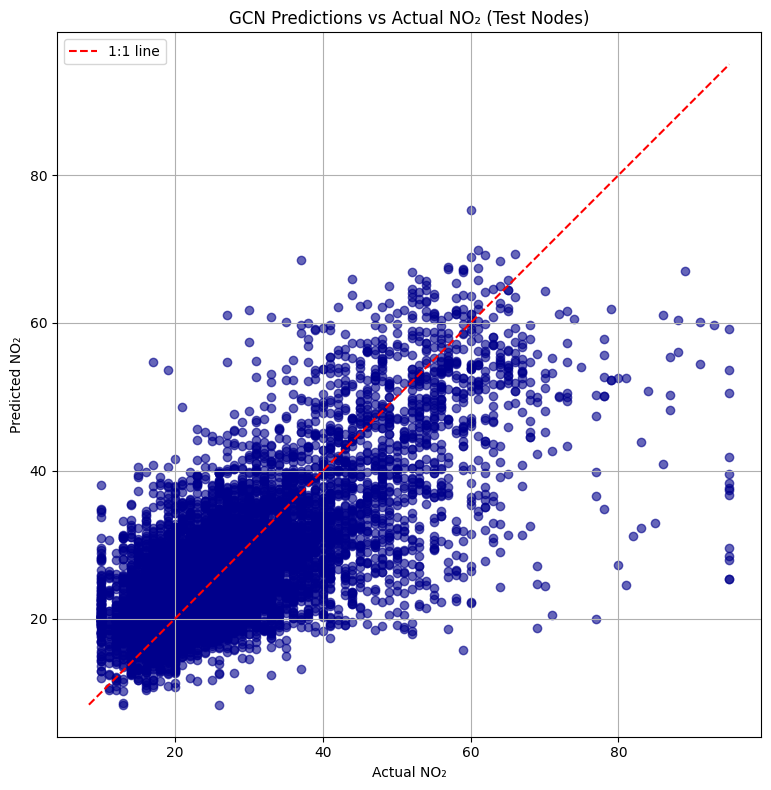

In [77]:
plt.figure(figsize=(8, 8))  # Make the figure square
plt.scatter(y_test, pred_test, alpha=0.6, color='darkblue')

# Plot a 1:1 reference line
min_val = min(y_test.min(), pred_test.min())
max_val = max(y_test.max(), pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 line')

# Labels and aesthetics
plt.xlabel('Actual NO₂')
plt.ylabel('Predicted NO₂')
plt.title('GCN Predictions vs Actual NO₂ (Test Nodes)')
plt.grid(True)
plt.axis('square')  # Force equal aspect ratio
plt.tight_layout()
plt.legend()
plt.show()

In [78]:
# Predict again (in case model was redefined or reloaded)
model.eval()
with torch.no_grad():
    pred_all = model(data.x, data.edge_index).cpu().numpy().flatten()

# Add predictions and true labels to the GeoDataFrame
gdf['NO2_actual'] = data.y.cpu().numpy().flatten()
gdf['NO2_pred'] = pred_all
gdf['NO2_error'] = gdf['NO2_pred'] - gdf['NO2_actual']

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

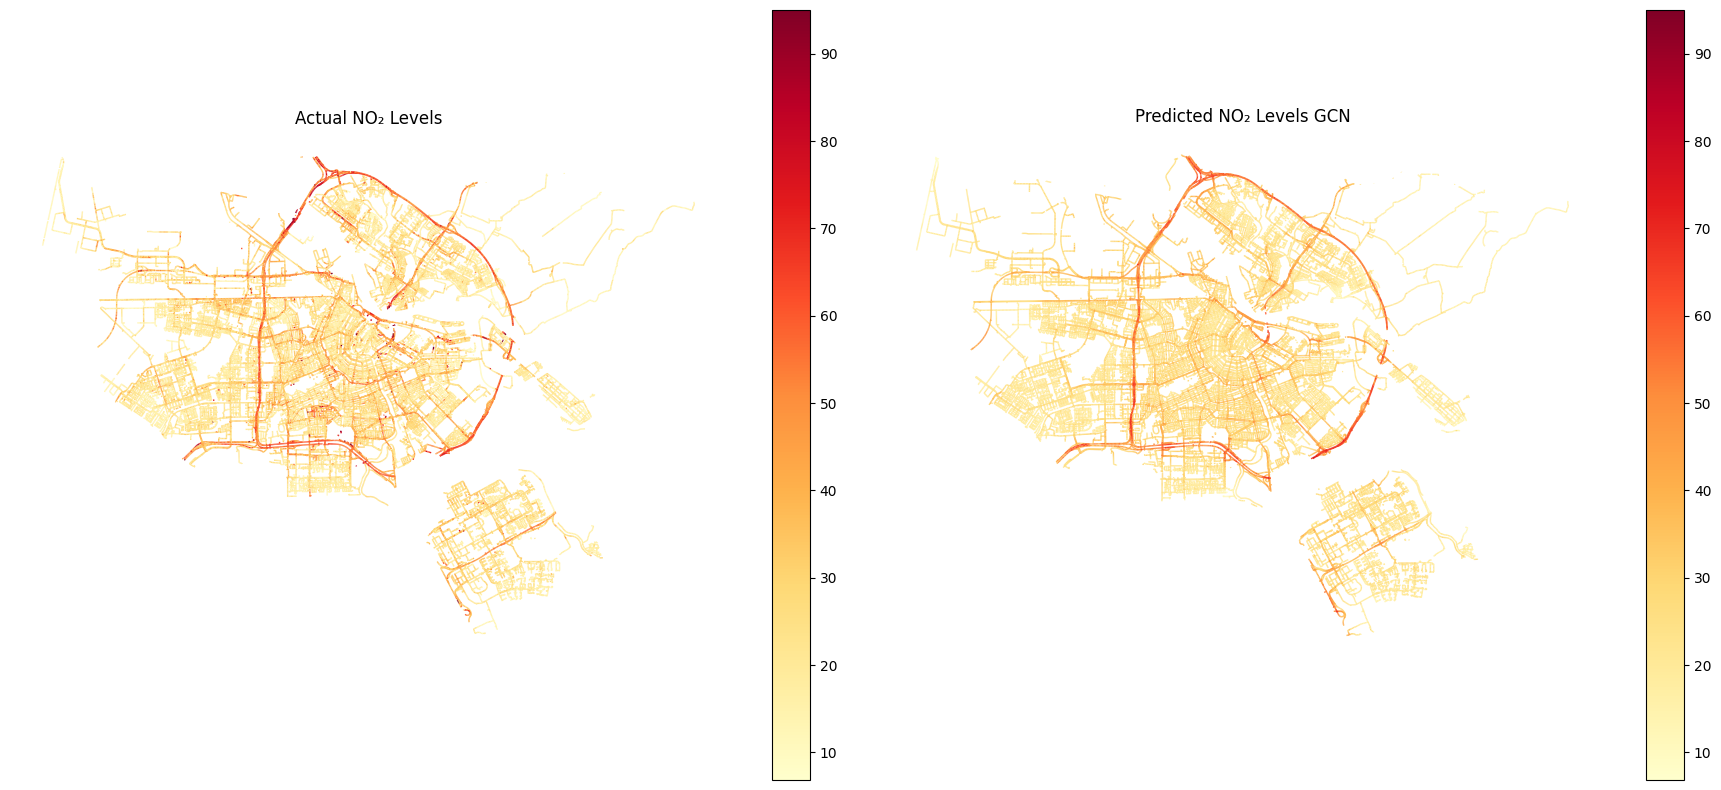

In [79]:
# Shared color scale limits
vmin = min(gdf['NO2_actual'].min(), gdf['NO2_pred'].min())
vmax = max(gdf['NO2_actual'].max(), gdf['NO2_pred'].max())

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Choose consistent colormap
cmap = 'YlOrRd'  # You can change this to 'YlGnBu' if preferred

# Actual NO2
gdf.plot(
    column='NO2_actual',
    cmap=cmap,
    linewidth=1,
    ax=axs[0],
    legend=True,
    vmin=vmin,
    vmax=vmax
)
axs[0].set_title('Actual NO₂ Levels')

# Predicted NO2
gdf.plot(
    column='NO2_pred',
    cmap=cmap,
    linewidth=1,
    ax=axs[1],
    legend=True,
    vmin=vmin,
    vmax=vmax
)
axs[1].set_title('Predicted NO₂ Levels GCN')

# Hide axes
for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

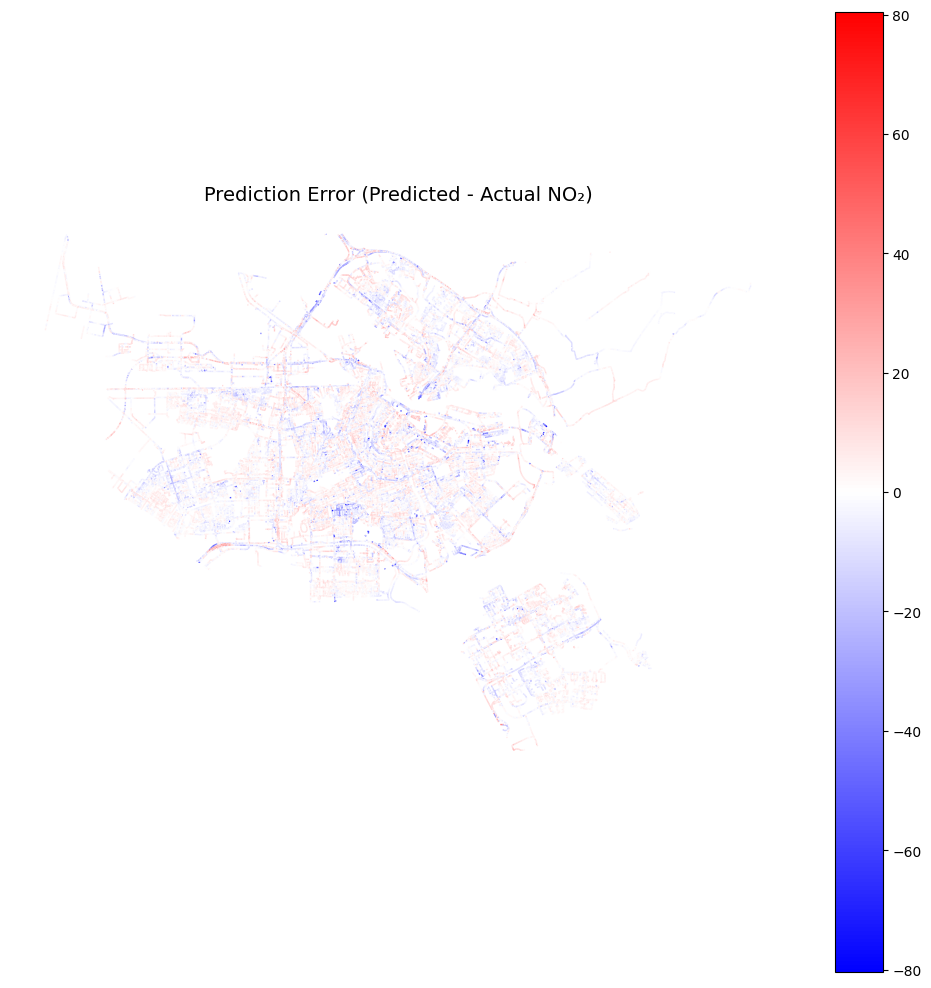

In [80]:
import matplotlib.colors as mcolors
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Find max absolute error
max_abs_error = gdf['NO2_error'].abs().max()

# Use TwoSlopeNorm centered at 0 with symmetric limits
norm = mcolors.TwoSlopeNorm(
    vmin=-max_abs_error,
    vcenter=0,
    vmax=max_abs_error
)

# Plot
gdf.plot(
    column='NO2_error',
    cmap='bwr',  # blue-white-red: blue = under, red = over
    linewidth=1,
    ax=ax,
    legend=True,
    norm=norm
)

ax.set_title("Prediction Error (Predicted - Actual NO₂)", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.show()


##External validation

External validation over 83 points:
  RMSE:    5.72
  MAE:     4.33
  R²:      0.18
  Pearson: 0.74


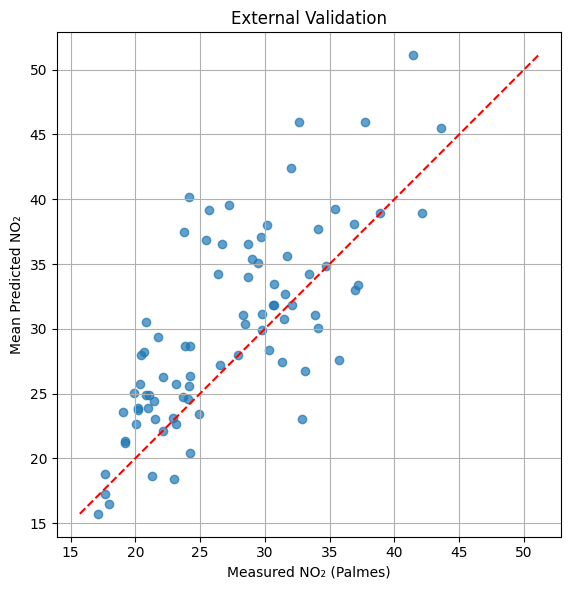

In [81]:
# 1. Load the Palmes measurement points
palmes_fp = '/content/drive/MyDrive/Universiteit Utrecht/Thesis/data/road_palmes_25m.geojson'
palmes_gdf = gpd.read_file(palmes_fp)

# 2. Make sure both GeoDataFrames share the same CRS
#    (your road‐segment gdf should already be in EPSG:28992)
palmes_gdf = palmes_gdf.to_crs(gdf.crs)

# 3. Build a spatial index over your road‐node GeoDataFrame
sindex = gdf.sindex

# 4. For each measurement point, find all nodes within `search_radius` (m)
search_radius = 50  # adjust to taste

mean_preds = []
actuals    = []

for _, row in palmes_gdf.iterrows():
    pt = row.geometry
    # fast bbox pre‐filter
    candidate_idxs = list(sindex.intersection(pt.buffer(search_radius).bounds))
    if len(candidate_idxs) > 0:
        # exact distance test
        geom_cand = gdf.loc[candidate_idxs, 'geometry']
        dists = geom_cand.distance(pt).values
        nearby = [candidate_idxs[i] for i, d in enumerate(dists) if d <= search_radius]
    else:
        nearby = []

    if len(nearby) == 0:
        # fallback to the single nearest road node
        nearest_idx = gdf.geometry.distance(pt).idxmin()
        nearby = [nearest_idx]

    # average the model’s predictions on those nodes
    preds = gdf.loc[nearby, 'NO2_pred']
    mean_pred = preds.mean()
    mean_preds.append(mean_pred)
    actuals.append(row['mean_annual_palmes_no2'])

# 5. Attach back to the Palmes GeoDataFrame
palmes_gdf['pred_mean'] = mean_preds
palmes_gdf['error']     = palmes_gdf['pred_mean'] - palmes_gdf['mean_annual_palmes_no2']

# 6. Compute external‐validation metrics
mse = mean_squared_error(actuals, mean_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, mean_preds)
r2  = r2_score(actuals, mean_preds)
pearson_corr, _ = pearsonr(actuals, mean_preds)

print(f"External validation over {len(actuals)} points:")
print(f"  RMSE:    {rmse:.2f}")
print(f"  MAE:     {mae:.2f}")
print(f"  R²:      {r2:.2f}")
print(f"  Pearson: {pearson_corr:.2f}")

# 7. (Optional) Scatter plot of measured vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(actuals, mean_preds, alpha=0.7)
mn, mx = min(min(actuals), min(mean_preds)), max(max(actuals), max(mean_preds))
plt.plot([mn,mx], [mn,mx], 'r--')
plt.xlabel('Measured NO₂ (Palmes)')
plt.ylabel('Mean Predicted NO₂')
plt.title('External Validation')
plt.grid(True)
plt.axis('square')
plt.tight_layout()
plt.show()

This part of the script trains and evaluates a Graph Attention Network (GAT) for NO₂ level prediction:

1. Define the GAT model:
   - Uses three GATConv layers with multi-head attention (2 heads in first two layers, 1 head in the output).
   - Applies ELU activation between layers to introduce non-linearity.

2. Set up training:
   - Define MSE loss and Adam optimizer.
   - Move data and model to GPU if available.

3. Train the model:
   - For 200 epochs, optimize using training nodes only (masked with train_mask).
   - Track both training and validation loss to monitor model performance over time.

4. Evaluate the model:
   - After training, make predictions on the test nodes.
   - Compute Mean Squared Error (MSE) and R² score to assess generalization.

5. Visualize results:
   - Plot training and validation loss curves to detect underfitting or overfitting.
   - Create a scatter plot comparing actual vs. predicted NO₂ values on the test set.

6. Apply the model to all nodes:
   - Predict NO₂ levels for the entire graph using the trained model.
   - Add actual, predicted, and error values to the GeoDataFrame.

7. Generate spatial visualizations:
   - Plot side-by-side maps of actual and predicted NO₂ levels across the road network.
   - Create a prediction error map using a diverging colormap (red = overprediction, blue = underprediction, white = no error).

These steps give both a quantitative evaluation of model performance and a spatial interpretation of how well the GAT captures NO₂ patterns.

In [82]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.gat3 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.gat3(x, edge_index)
        return x


<ipython-input-83-c29ffb759b49>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pearson_corr = float(pearson_corr)


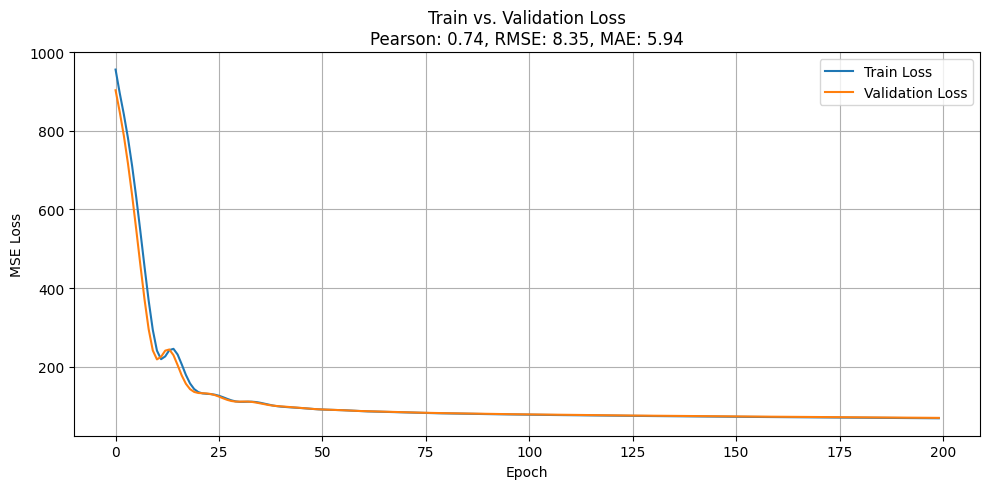

In [83]:
# Define model, optimizer, loss function
loss_fn = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Initialize GAT model and optimizer
model = GAT(in_channels=len(feature_cols), hidden_channels=16, out_channels=1, heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
val_losses = []

# Training loop with both train and validation loss
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        val_loss = loss_fn(out[data.test_mask], data.y[data.test_mask])

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

# Evaluation after training
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index)
    pred_test = pred[data.test_mask].cpu().numpy()
    y_test = data.y[data.test_mask].cpu().numpy()

# Metrics
mse = mean_squared_error(y_test, pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)
pearson_corr, _ = pearsonr(y_test, pred_test)
pearson_corr = float(pearson_corr)

# Plot both train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'Train vs. Validation Loss\nPearson: {pearson_corr:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

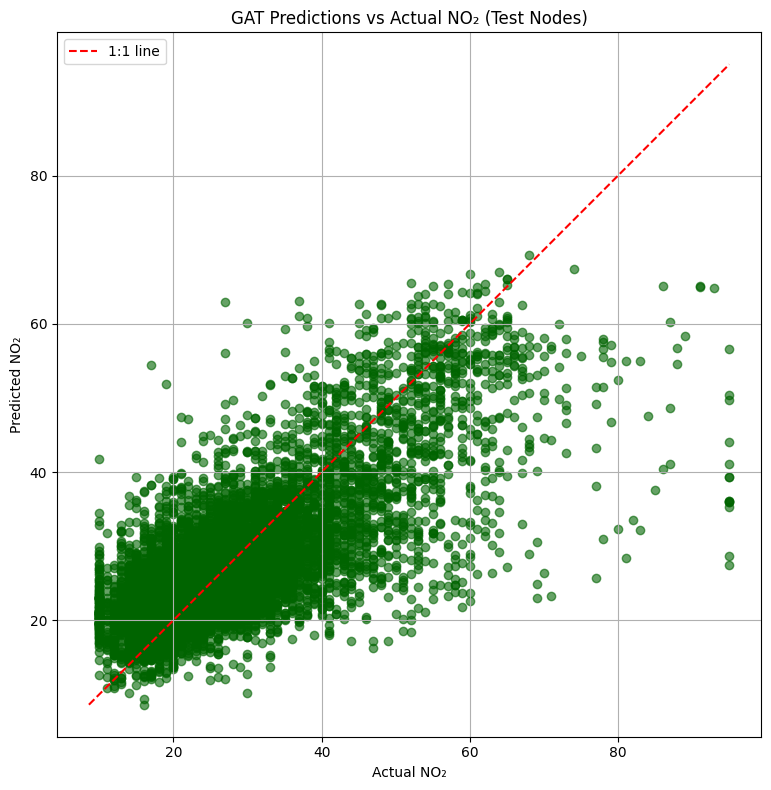

In [84]:
plt.figure(figsize=(8, 8))  # Make the figure square
plt.scatter(y_test, pred_test, alpha=0.6, color='darkgreen')  # GAT predictions

# Plot 1:1 reference line
min_val = min(y_test.min(), pred_test.min())
max_val = max(y_test.max(), pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 line')

# Labels and aesthetics
plt.xlabel('Actual NO₂')
plt.ylabel('Predicted NO₂')
plt.title('GAT Predictions vs Actual NO₂ (Test Nodes)')
plt.grid(True)
plt.axis('square')  # Force equal aspect ratio
plt.tight_layout()
plt.legend()
plt.show()

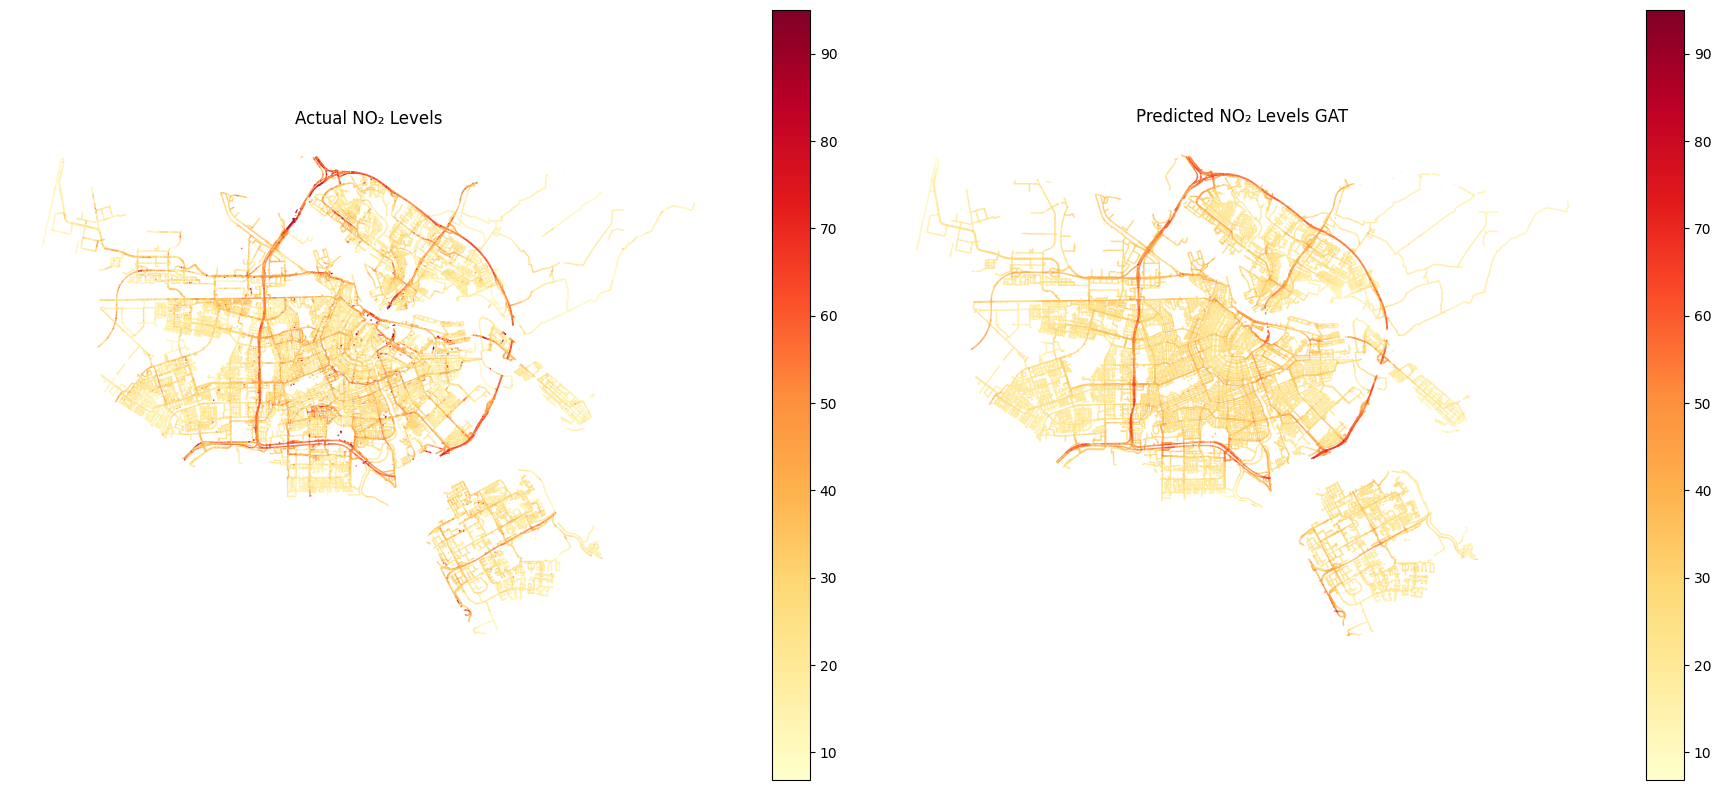

In [85]:
# Shared color scale limits
vmin = min(gdf['NO2_actual'].min(), gdf['NO2_pred'].min())
vmax = max(gdf['NO2_actual'].max(), gdf['NO2_pred'].max())

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Choose consistent colormap
cmap = 'YlOrRd'  # You can change this to 'YlGnBu' if preferred

# Actual NO2
gdf.plot(
    column='NO2_actual',
    cmap=cmap,
    linewidth=1,
    ax=axs[0],
    legend=True,
    vmin=vmin,
    vmax=vmax
)
axs[0].set_title('Actual NO₂ Levels')

# Predicted NO2
gdf.plot(
    column='NO2_pred',
    cmap=cmap,
    linewidth=1,
    ax=axs[1],
    legend=True,
    vmin=vmin,
    vmax=vmax
)
axs[1].set_title('Predicted NO₂ Levels GAT')

# Hide axes
for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

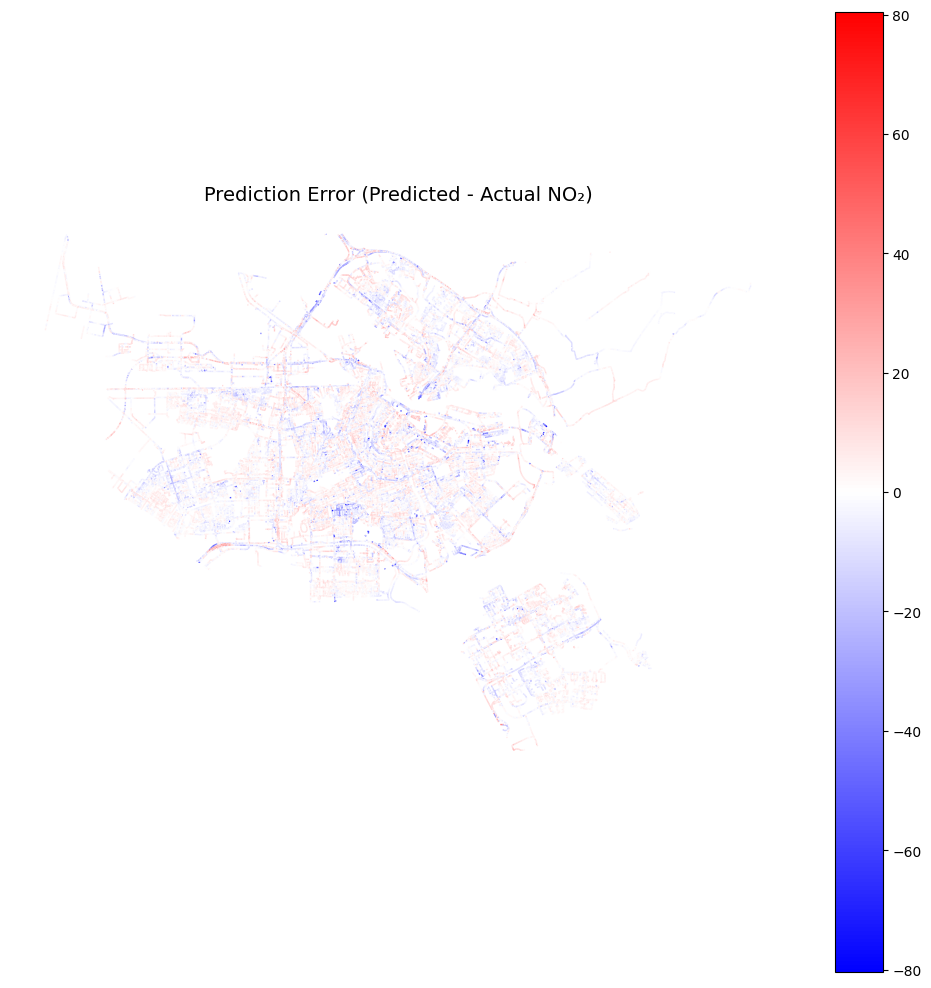

In [86]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Find max absolute error
max_abs_error = gdf['NO2_error'].abs().max()

# Use TwoSlopeNorm centered at 0 with symmetric limits
norm = mcolors.TwoSlopeNorm(
    vmin=-max_abs_error,
    vcenter=0,
    vmax=max_abs_error
)

# Plot
gdf.plot(
    column='NO2_error',
    cmap='bwr',  # blue-white-red: blue = under, red = over
    linewidth=1,
    ax=ax,
    legend=True,
    norm=norm
)

ax.set_title("Prediction Error (Predicted - Actual NO₂)", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.show()


## External validation

External validation over 83 points:
  RMSE:    5.72
  MAE:     4.33
  R²:      0.18
  Pearson: 0.74


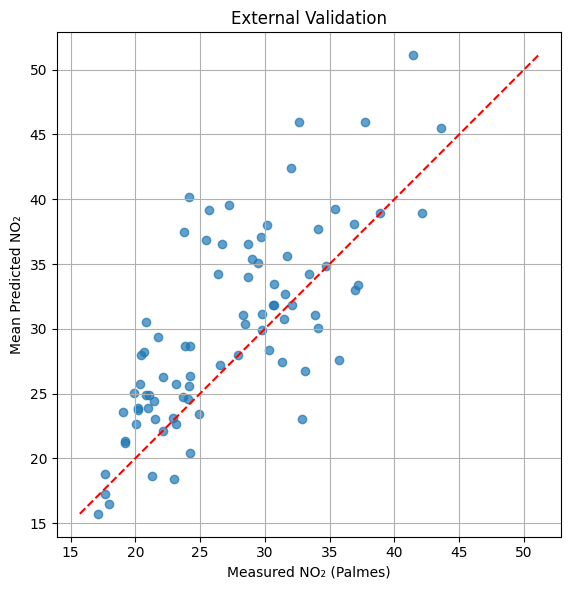

In [87]:
# 1. Load the Palmes measurement points
palmes_fp = '/content/drive/MyDrive/Universiteit Utrecht/Thesis/data/road_palmes_25m.geojson'
palmes_gdf = gpd.read_file(palmes_fp)

# 2. Make sure both GeoDataFrames share the same CRS
palmes_gdf = palmes_gdf.to_crs(gdf.crs)

# 3. Build a spatial index over your road‐node GeoDataFrame
sindex = gdf.sindex

# 4. For each measurement point, find all nodes within `search_radius` (m)
search_radius = 50  # adjust to taste

mean_preds = []
actuals    = []

for _, row in palmes_gdf.iterrows():
    pt = row.geometry
    # fast bbox pre‐filter
    candidate_idxs = list(sindex.intersection(pt.buffer(search_radius).bounds))
    if len(candidate_idxs) > 0:
        # exact distance test
        geom_cand = gdf.loc[candidate_idxs, 'geometry']
        dists = geom_cand.distance(pt).values
        nearby = [candidate_idxs[i] for i, d in enumerate(dists) if d <= search_radius]
    else:
        nearby = []

    if len(nearby) == 0:
        # fallback to the single nearest road node
        nearest_idx = gdf.geometry.distance(pt).idxmin()
        nearby = [nearest_idx]

    # average the model’s predictions on those nodes
    preds = gdf.loc[nearby, 'NO2_pred']
    mean_pred = preds.mean()
    mean_preds.append(mean_pred)
    actuals.append(row['mean_annual_palmes_no2'])

# 5. Attach back to the Palmes GeoDataFrame
palmes_gdf['pred_mean'] = mean_preds
palmes_gdf['error']     = palmes_gdf['pred_mean'] - palmes_gdf['mean_annual_palmes_no2']

# 6. Compute external‐validation metrics
mse = mean_squared_error(actuals, mean_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, mean_preds)
r2  = r2_score(actuals, mean_preds)
pearson_corr, _ = pearsonr(actuals, mean_preds)

print(f"External validation over {len(actuals)} points:")
print(f"  RMSE:    {rmse:.2f}")
print(f"  MAE:     {mae:.2f}")
print(f"  R²:      {r2:.2f}")
print(f"  Pearson: {pearson_corr:.2f}")

# 7. (Optional) Scatter plot of measured vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(actuals, mean_preds, alpha=0.7)
mn, mx = min(min(actuals), min(mean_preds)), max(max(actuals), max(mean_preds))
plt.plot([mn,mx], [mn,mx], 'r--')
plt.xlabel('Measured NO₂ (Palmes)')
plt.ylabel('Mean Predicted NO₂')
plt.title('External Validation')
plt.grid(True)
plt.axis('square')
plt.tight_layout()
plt.show()